In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [14]:
import os.path
import re
import subprocess
import sys
import math

In [3]:
MODELS_DIR = 'models'
MODELNAME = 'iter%d.model'
LABELED_DATA = os.path.join('data', 'labeled.dat')
UNLABELED_DATA = os.path.join('data', 'unlabeled.dat')
VW_CODE_DIR = os.path.join(os.pardir, os.pardir, 'deps', 'vowpal_wabbit')
VW_EXEC_DIR = os.path.join(VW_CODE_DIR, 'vowpalwabbit')

Load the points from the labeled dataset

In [4]:
points = []

with open(LABELED_DATA) as truthdata:
    while True:
        l = truthdata.readline()
        if l == '':
            break
        m = re.match('(\d).*\| x:(\d.\d{2}) y:(\d.\d{2})', l)
        p = {
            'label': int(m.group(1)),
            'x': float(m.group(2)),
            'y': float(m.group(3)),
        }
        points.append(p)

Plot expected labels for data

In [5]:
x0 = [p['x'] for p in points if p['label'] == 0]
y0 = [p['y'] for p in points if p['label'] == 0]
x1 = [p['x'] for p in points if p['label'] == 1]
y1 = [p['y'] for p in points if p['label'] == 1]

(0, 1)

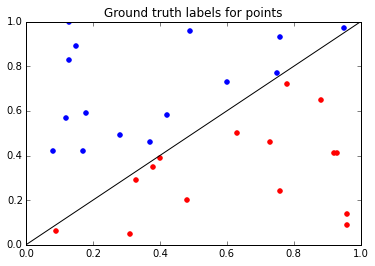

In [6]:
scatter(x0, y0, color='r')
hold('on')
scatter(x1, y1, color='b')
hold('on')
plot(linspace(0, 1, 101), linspace(0, 1, 101), color='k')
title("Ground truth labels for points")
xlim(0, 1)
ylim(0, 1)

Get variable names from hashes

In [7]:
output = subprocess.check_output(
    ['utl/vw-varinfo', os.path.abspath(UNLABELED_DATA)], 
    stderr=subprocess.STDOUT,
    cwd=VW_CODE_DIR,
    env=dict(os.environ, PATH=os.environ['PATH'] + ':' + VW_EXEC_DIR)
)

In [8]:
varhashes = {}
for l in output.split('\n')[1:]:
    if l != '':
        m = re.match('\^?([^\s]+)\s*(\d+).*', l)
        name = m.group(1)
        hash_ = int(m.group(2))
        varhashes[hash_] = name

Read in coefficients for models

In [9]:
file_index = 1
iterations = []
while True:
    modelfile = os.path.join(MODELS_DIR, MODELNAME % file_index)
    coefficients = {}
    if os.path.exists(modelfile):
        with open(modelfile) as mfile:
            text = mfile.read()
            for vhash, vname in varhashes.items():
                m = re.search('^' + str(vhash) + ':(.*)$', text, re.MULTILINE)
                if m is not None:
                    coefficients[vname] = float(m.group(1))
    else:
        break
    iterations.append(coefficients)
    file_index += 1

We can convert between the model that VW provides us and a decision boundary as follows.
Let's assume that VW will declare a point with a label of 1 if the hypothesis predicts >=1/2, and a label of 0 if below.
Then the decision boundary occurs at

    constant + a*x + b*y = 1/2
   
Solving this equation for y, we get the equation:

$$y = \frac{1}{b} (-ax + (-c + \frac{1}{2}))$$

In [10]:
def model_to_boundary(constant, xcoeff, ycoeff):
    return lambda x: (1 / ycoeff) * (((-1) * xcoeff * x) + (-constant + .5))

Show every third model so that we can see how the decision boundary changes over time for active learning

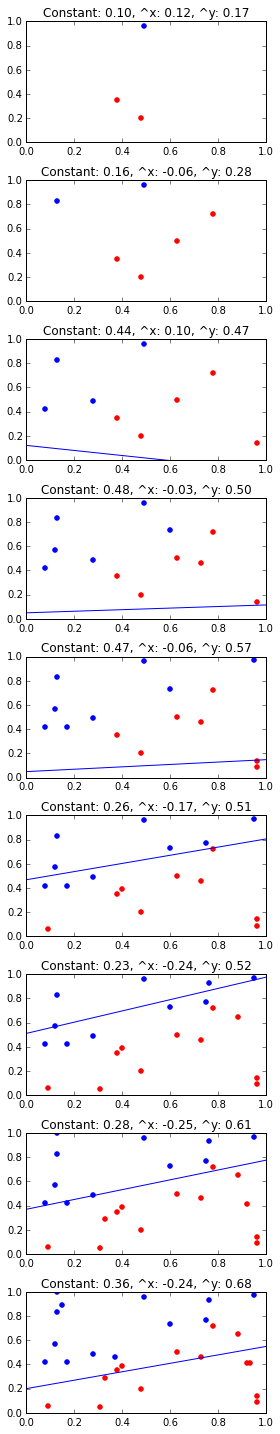

In [15]:
STEP = 3
subplot_count = math.ceil(len(iterations) / float(STEP))
subplot_idx = 1

fig = figure(figsize=(4,20))

for idx, coeff in enumerate(iterations):
    
    if not idx % STEP == 0:
        continue
    if coeff == {}:
        subplot_count -= 1
        continue
        
    subplot(subplot_count, 1, subplot_idx)
    subplot_idx += 1
    
    # Make the boundary
    x = linspace(0, 1, 101)
    boundary = model_to_boundary(coeff['Constant'], coeff['x'], coeff['y'])
    y = [boundary(xi) for xi in x]
    
    # Get points for the current examples
    num_points = idx
    examples = points[:idx]
    ex0 = [p['x'] for p in examples if p['label'] == 0]
    ey0 = [p['y'] for p in examples if p['label'] == 0]
    ex1 = [p['x'] for p in examples if p['label'] == 1]
    ey1 = [p['y'] for p in examples if p['label'] == 1]    
    
    scatter(ex0, ey0, color='r')
    hold('on')
    scatter(ex1, ey1, color='b')
    hold('on')
    plot(x, y)
    xlim(0,1)
    ylim(0,1)
    title("Constant: %.2f, ^x: %.2f, ^y: %.2f" % (coeff['Constant'], coeff['x'], coeff['y']))

tight_layout()